# Bottle Cap Detection - Ada Mata Take Home Test

# Project Description

The goal of this take-home test is to design, implement, and explain a complete computer-vision pipeline to detect bottle caps from a set of sample images. The dataset consists of 12 images and annotation files in YOLO bounding-box format. Each image contains several bottle caps of the same color.

# Import Libraries

In [1]:
import os
import re
import glob
import shutil
import cv2

from tqdm import tqdm

import matplotlib.pyplot as plt

import os

# Dataset Preview

In [2]:
class YOLODatasetVisualizer:
    """
    Visualize YOLO-format bounding boxes for a set of images.
    """

    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_paths = sorted(glob.glob(os.path.join(self.image_dir, "*.jpg")))

        # Color mapping (BGR)
        self.bbox_colors = {
            0: (255, 255, 255),   # white box
            1: (255, 200, 100),   # light blue
            2: (100, 0, 0),       # dark blue
        }

        # Text color mapping (BGR)
        self.text_colors = {
            0: (42, 42, 165),     # brown
            1: (255, 255, 255),   # white
            2: (255, 255, 255),   # white
        }

        # Class name mapping
        self.class_names = {
            0: "light_blue",
            1: "dark_blue",
            2: "other",
        }

    def load_yolo_annotation(self, label_path):
        """Load YOLO labels from .txt file."""
        boxes = []
        if not os.path.exists(label_path):
            return boxes

        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    cls, x, y, w, h = parts
                    boxes.append((int(cls), float(x), float(y), float(w), float(h)))
        return boxes

    def draw_yolo_boxes(self, image, boxes, thickness=2):
        """Draw YOLO bounding boxes onto an image with class-based colors."""
        h, w = image.shape[:2]
        img = image.copy()

        for cls, x, y, bw, bh in boxes:
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)

            # Select colors
            box_color = self.bbox_colors.get(cls, (255, 255, 255))
            text_color = self.text_colors.get(cls, (255, 255, 255))

            # Get class name
            cls_name = self.class_names.get(cls, "unknown")

            # Draw rectangle
            cv2.rectangle(img, (x1, y1), (x2, y2), box_color, thickness)

            # Draw text above box
            cv2.putText(
                img,
                f"{cls_name}",
                (x1, y1 - 7),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                text_color,
                2
            )

        return img

    def visualize_grid(self, rows=4, cols=3, figsize=(14, 18)):
        """
        Display images and their YOLO boxes in a grid.
        """

        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()

        for idx, img_path in enumerate(self.image_paths):
            if idx >= rows * cols:
                break

            file_name = os.path.basename(img_path).replace(".jpg", ".txt")
            label_path = os.path.join(self.label_dir, file_name)

            # Load image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Load labels
            boxes = self.load_yolo_annotation(label_path)

            # Draw boxes
            annotated = self.draw_yolo_boxes(img, boxes)

            # Title shows total box count
            axes[idx].imshow(annotated)
            axes[idx].set_title(f"{os.path.basename(img_path)}\n{len(boxes)} boxes", fontsize=11)
            axes[idx].axis("off")

        for j in range(len(self.image_paths), rows * cols):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    def run(self, rows=4, cols=3):
        """Execute full visualization."""
        self.visualize_grid(rows=rows, cols=cols)

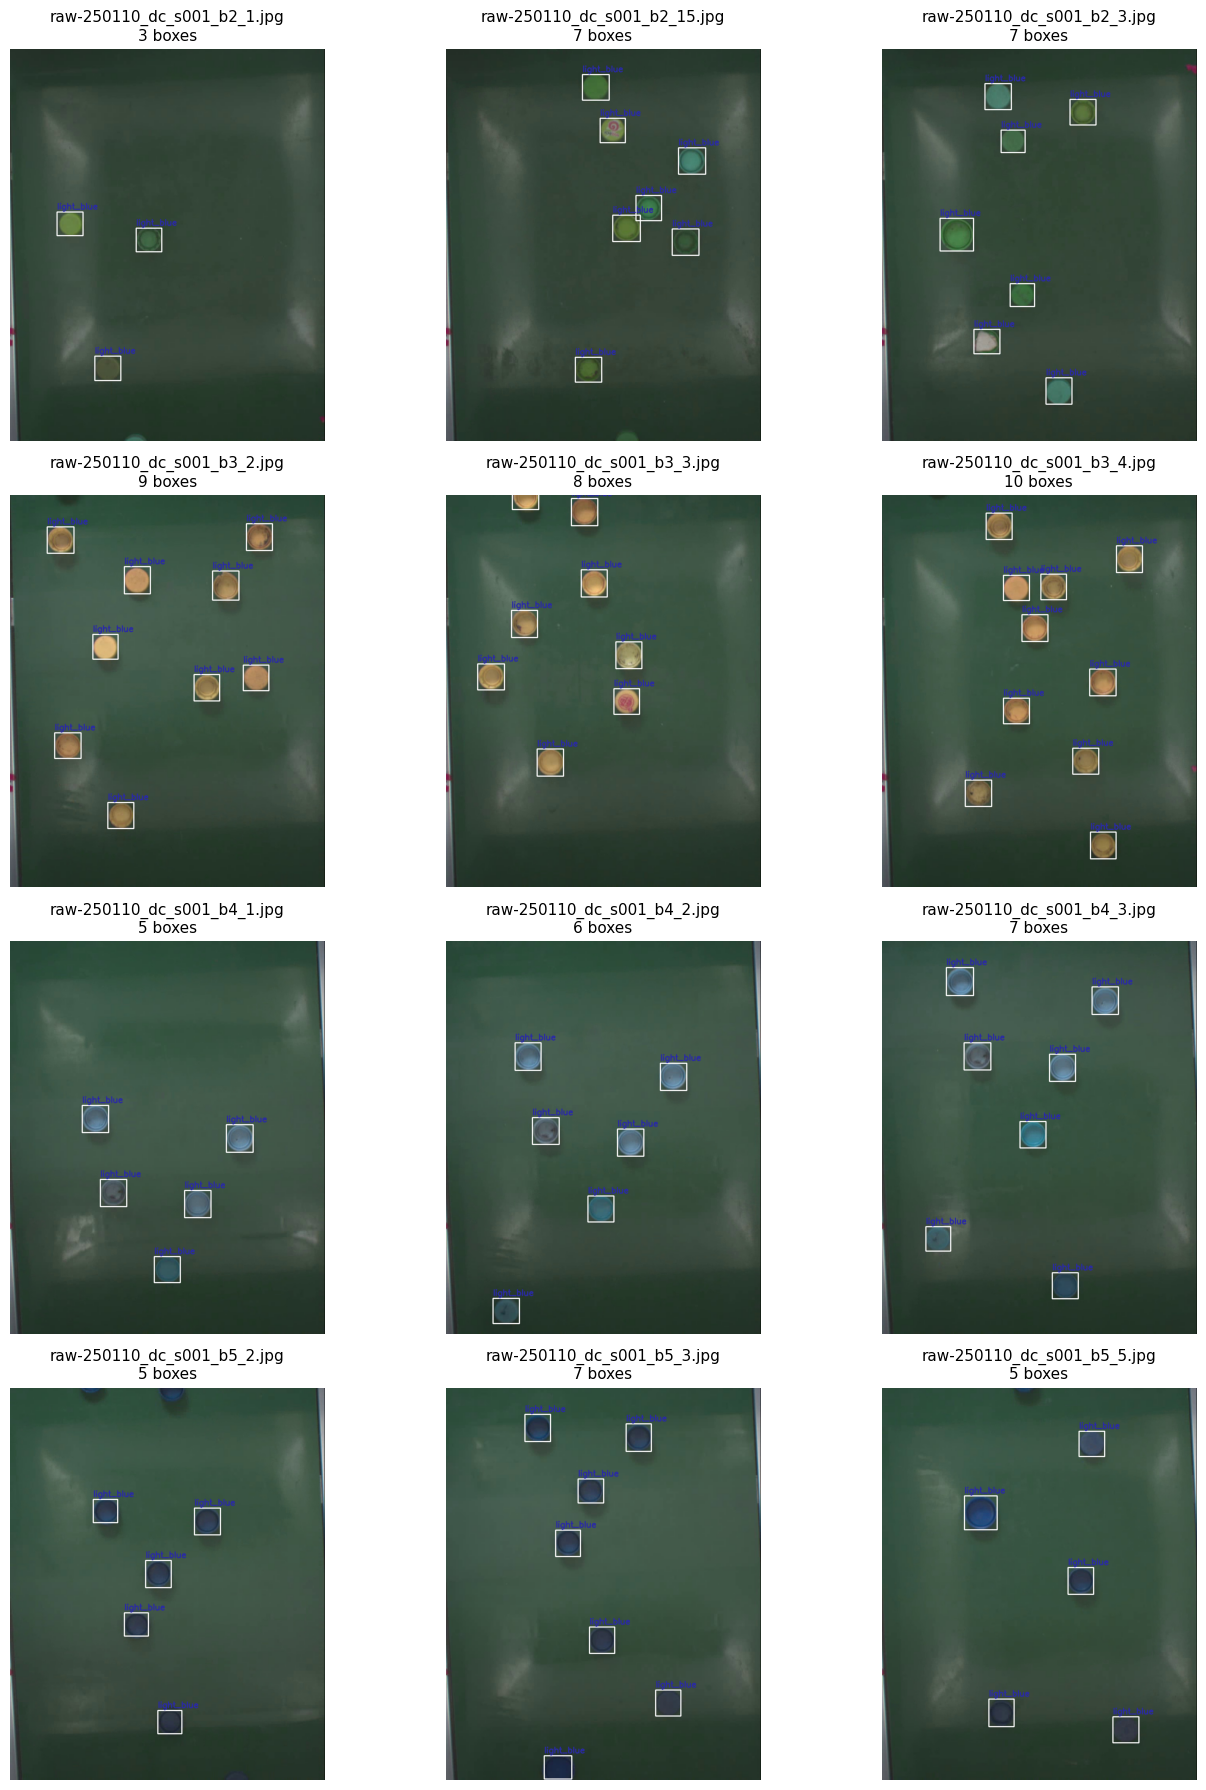

In [3]:
visualizer_raw = YOLODatasetVisualizer(
    image_dir="../data/images_raw",
    label_dir="../data/labels_raw"
)

visualizer_raw.run(rows=4, cols=3)

**Data Preview Summary**

Based on the data preview results, several important observations can be made regarding the structure and composition of the dataset:

1. **The dataset contains a total of 12 images.**
   
   Each image represents a single capture containing multiple bottle caps placed on a tray.

2. **Every image includes several bottle caps**
   
   typically scattered across the surface, with varying counts depending on the sample.

3. **The dataset is composed of four color groups**, each represented by exactly three images:

   * **Green** bottle caps → 3 images
   * **Orange** bottle caps → 3 images
   * **Light blue** bottle caps → 3 images
   * **Dark blue** bottle caps → 3 images

4. **The color information can be inferred from the filename structure**, where:

   * `b2` → Green
   * `b3` → Orange
   * `b4` → Light Blue
   * `b5` → Dark Blue

5. **The YOLO annotation files do not contain class labels.**
   
   All annotations use the default class value **0**, indicating that class-specific information was not provided and must be incorporated through relabeling or class mapping.


# Relabel

**Relabeling Strategy**

Based on the dataset preview, the YOLO annotation files provided do not contain class information. All bounding box entries are assigned to class **0**, meaning that the original dataset does not distinguish bottle caps by color.
To correctly prepare the data for a color-based bottle cap detection task, relabeling is required.

The relabeling process is performed using the filename pattern, where each image contains a specific color group and the corresponding color code can be extracted from the filename:

* `b2` → Green
* `b3` → Orange
* `b4` → Light Blue
* `b5` → Dark Blue

Because the task given is to detect light blue, dark blue and other colored bottle caps. Images containing green and orange bottle caps will be mapped to the **"other"** category.

---

**Relabeling Rules**

| Color Code | Color Group | New Class ID | Reasoning                    |
| ---------- | ----------- | ------------ | ---------------------------- |
| **b2**     | Green       | **2**        | Merged into “other” class    |
| **b3**     | Orange      | **2**        | Merged with green as “other” |
| **b4**     | Light Blue  | **0**        | Unique class                 |
| **b5**     | Dark Blue   | **1**        | Unique class                 |

In [4]:
class LabelRelabeler:
    """
    Relabel YOLO annotation files based on color-group mapping extracted from filename.
    """

    def __init__(self, label_dir, out_dir, color_map):
        self.label_dir = label_dir
        self.out_dir = out_dir
        self.color_map = color_map

        os.makedirs(self.out_dir, exist_ok=True)

    def extract_code(self, filename):
        """Extract b-code (e.g., b2, b3, b4, b5) from filename."""
        match = re.search(r"_b(\d)_", filename)
        if not match:
            return None
        return "b" + match.group(1)

    def relabel_file(self, fname):
        """Relabel a single YOLO label file based on its color group."""
        code = self.extract_code(fname)
        if code is None:
            print(f"[WARN] Skip: missing b-code in {fname}")
            return

        if code not in self.color_map:
            print(f"[WARN] Skip: no mapping for {code} in {fname}")
            return

        new_class = self.color_map[code]

        in_path = os.path.join(self.label_dir, fname)
        out_path = os.path.join(self.out_dir, fname)

        with open(in_path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            parts[0] = str(new_class)
            new_lines.append(" ".join(parts) + "\n")

        with open(out_path, "w") as f:
            f.writelines(new_lines)

    def run(self):
        """Process all label files in the directory."""
        txt_files = [f for f in os.listdir(self.label_dir) if f.endswith(".txt")]

        print(f"Found {len(txt_files)} label files. Starting relabeling...\n")

        for fname in tqdm(txt_files, desc="Relabeling", unit="file"):
            self.relabel_file(fname)

        print("\nRelabeling completed successfully!")
        print(f"Updated label files are saved in: {os.path.abspath(self.out_dir)}")

In [5]:
COLOR_MAP = {
    "b2": 2,   # green → other
    "b3": 2,   # orange → other
    "b4": 0,   # light blue
    "b5": 1,   # dark blue
}

relabeler = LabelRelabeler(
    label_dir="../data/labels_raw",
    out_dir="../data/labels",
    color_map=COLOR_MAP
)

relabeler.run()

Found 12 label files. Starting relabeling...



Relabeling: 100%|██████████| 12/12 [00:00<00:00, 1195.70file/s]


Relabeling completed successfully!
Updated label files are saved in: d:\Company Take Home Test\Ada Mata - Machine Learning Engineer\data\labels


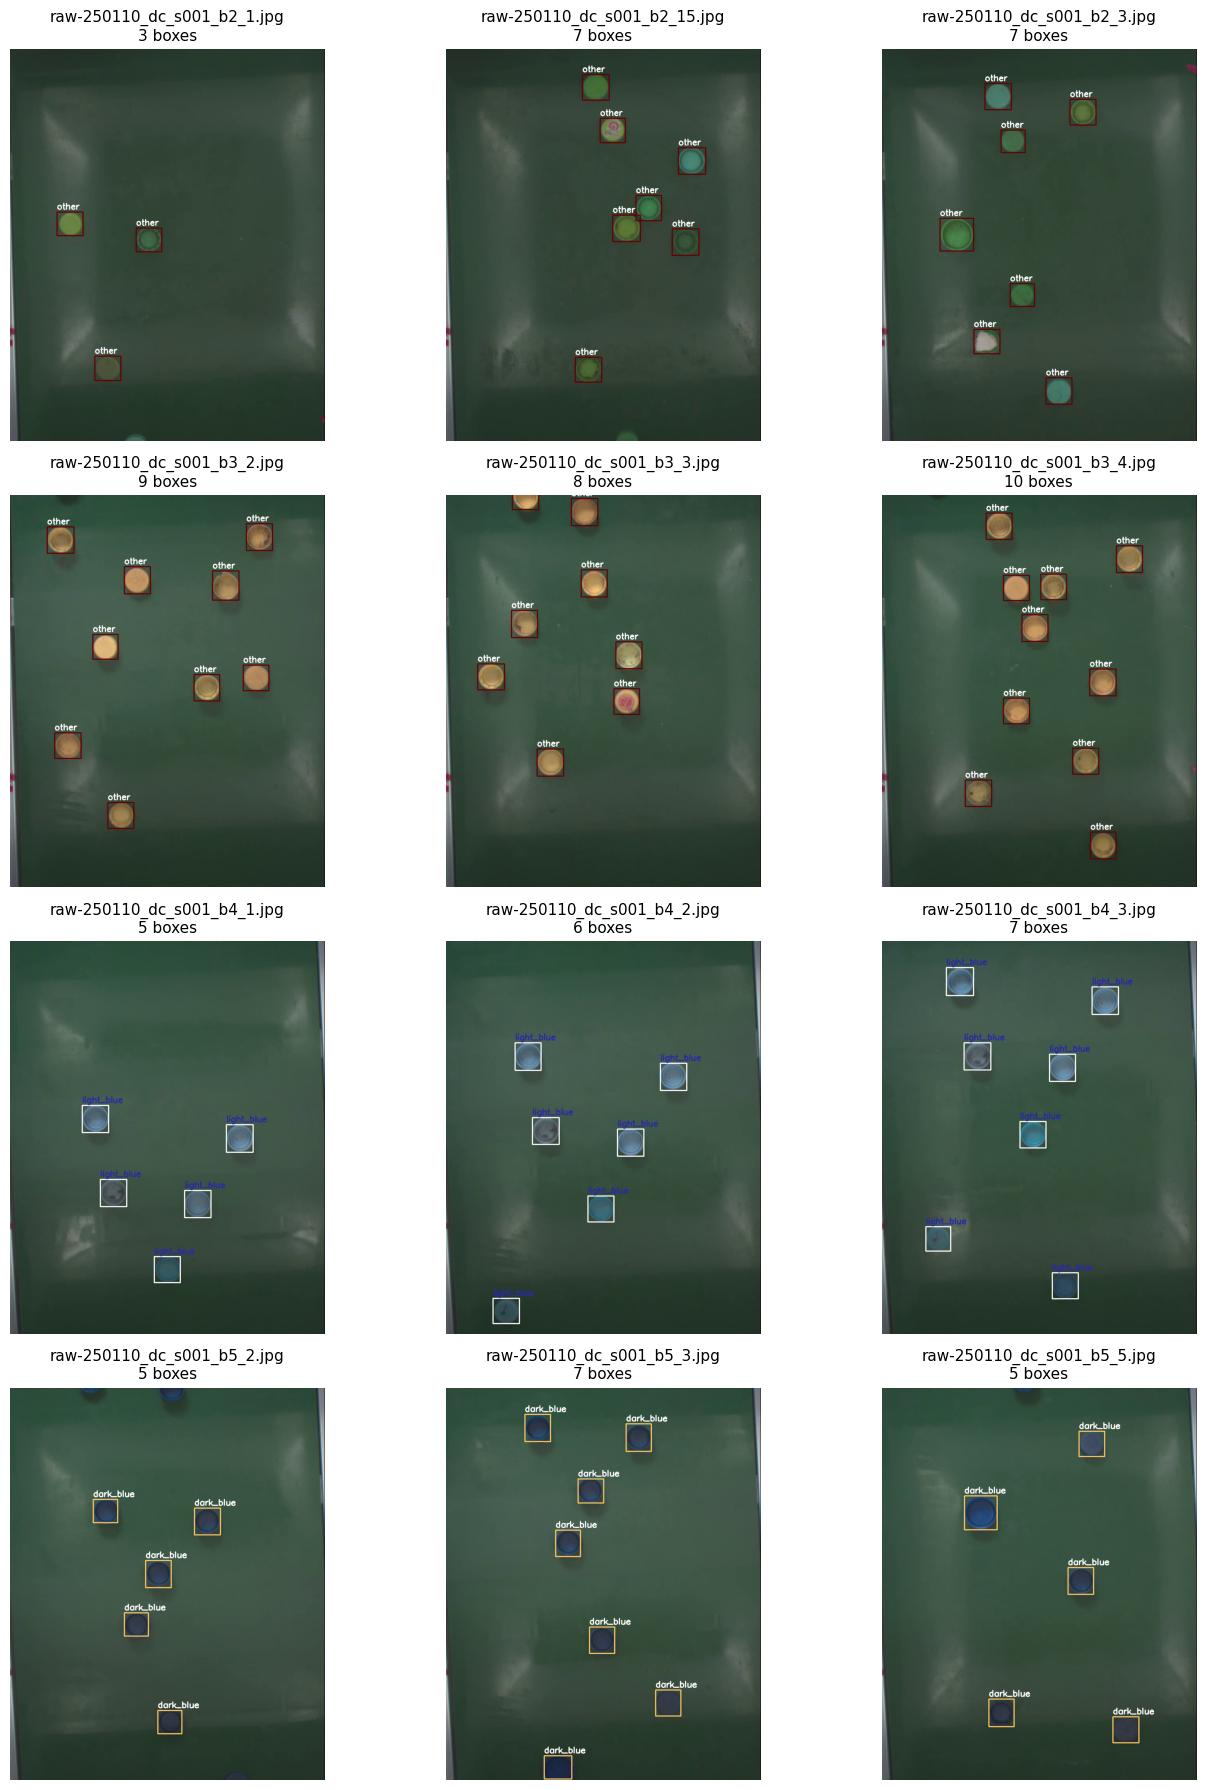

In [6]:
visualizer_relabel = YOLODatasetVisualizer(
    image_dir="../data/images_raw",
    label_dir="../data/relabels"
)

visualizer_relabel.run(rows=4, cols=3)

# Split Dataset

**Dataset Splitting Strategy**

After completing the relabeling process, the next step is to split the dataset into **training** and **validation** subsets.
Since the dataset contains exactly **12 images**, grouped evenly by color type, a standard random split would risk causing class imbalance in the validation set.
To avoid this issue, a **stratified split based on color groups** is implemented.

---

**Rationale for Stratified Splitting**
Because each color group contains **exactly 3 images**, the split must ensure:

* Every color group contributes to **both** train and validation sets.
* No class is missing in the validation set.
* Model evaluation remains consistent and representative.

Therefore, the dataset is split as:

* **2 images → training**
* **1 image → validation**

per color group.

This maintains a **balanced class distribution** across both subsets.

---
**Splitting Rules**

1. **Extract b-code from filename**
   Example:

   ```
   raw-250110_dc_s001_b3_3.jpg → b3 (orange)
   ```

2. **Group images by color bucket**
   Four buckets are created:

   * `other_b2`
   * `other_b3`
   * `lightblue_b4`
   * `darkblue_b5`

3. **Inside each bucket**

   * Sort filenames to ensure deterministic order
   * Assign:

     * **First 2** images → Train
     * **Last 1** image → Validation

4. **Copy both images and their label files**
   For each selected `.jpg`, the corresponding `.txt` file is also copied to the appropriate folder.

5. **All output directories are cleaned and recreated**
   Ensures the split is reproducible and not contaminated with previous runs.

In [7]:
class DatasetSplitter:
    """
    Stratified dataset splitter for bottle-cap classification.
    Splits images and YOLO labels into train/val sets based on color groups.
    """

    def __init__(self, img_dir, lbl_dir, out_img_train, out_img_val, out_lbl_train, out_lbl_val):
        self.img_dir = img_dir
        self.lbl_dir = lbl_dir
        self.out_img_train = out_img_train
        self.out_img_val = out_img_val
        self.out_lbl_train = out_lbl_train
        self.out_lbl_val = out_lbl_val

        # Mapping from b-code to color group
        self.color_group = {
            "2": "other_b2",
            "3": "other_b3",
            "4": "lightblue_b4",
            "5": "darkblue_b5",
        }

        # Buckets for each b-category
        self.buckets = {
            "other_b2": [],
            "other_b3": [],
            "lightblue_b4": [],
            "darkblue_b5": [],
        }

    def clean_output_dirs(self):
        """Remove old output directories and recreate empty folders."""
        dirs = [
            self.out_img_train, self.out_img_val,
            self.out_lbl_train, self.out_lbl_val
        ]

        for d in dirs:
            if os.path.exists(d):
                shutil.rmtree(d)
            os.makedirs(d, exist_ok=True)

        print("[INFO] Output folders cleaned and recreated.\n")

    def categorize_files(self):
        """Categorize images into buckets based on filename b-code."""
        print("[INFO] Categorizing files into buckets...")

        for fname in tqdm(os.listdir(self.img_dir), desc="Categorizing", unit="file"):
            if not fname.endswith(".jpg"):
                continue

            match = re.search(r"_b(\d)_", fname)
            if not match:
                print(f"[WARN] Skip {fname}: missing b-code pattern.")
                continue

            bcode = match.group(1)
            key = self.color_group.get(bcode)

            if key:
                self.buckets[key].append(fname)
            else:
                print(f"[WARN] Unknown b-code: {fname}")

        print("[INFO] Files categorized into buckets.\n")

    def split_and_copy(self):
        """
        Perform stratified split: 2 train, 1 val for each bucket.
        Copies corresponding .jpg and .txt files.
        """
        print("[INFO] Performing stratified split and copying files...")

        for key, files in tqdm(self.buckets.items(), desc="Splitting Buckets"):
            files = sorted(files)

            if len(files) != 3:
                print(f"[WARN] {key} expected 3 files, got {len(files)}")

            train_files = files[:2]
            val_files = files[2:]

            # Copy training files (LABEL FIRST)
            for f in train_files:
                label_src = os.path.join(self.lbl_dir, f.replace(".jpg", ".txt"))
                try:
                    shutil.copy(label_src, self.out_lbl_train)
                    shutil.copy(os.path.join(self.img_dir, f), self.out_img_train)
                except FileNotFoundError:
                    print(f"[WARN] Missing label for {f}. Skipping.")
                    continue

            # Copy validation files (LABEL FIRST)
            for f in val_files:
                label_src = os.path.join(self.lbl_dir, f.replace(".jpg", ".txt"))
                try:
                    shutil.copy(label_src, self.out_lbl_val)
                    shutil.copy(os.path.join(self.img_dir, f), self.out_img_val)
                except FileNotFoundError:
                    print(f"[WARN] Missing label for {f}. Skipping.")
                    continue

        print("\n[INFO] Stratified split completed.\n")

    def run(self):
        """Execute the full pipeline."""
        self.clean_output_dirs()
        self.categorize_files()
        self.split_and_copy()

        # Output summary
        print("====================================================")
        print(" Dataset Split Completed Successfully!")
        print("----------------------------------------------------")
        print(f" Training Images : {os.path.abspath(self.out_img_train)}")
        print(f" Training Labels : {os.path.abspath(self.out_lbl_train)}")
        print("----------------------------------------------------")
        print(f" Validation Images : {os.path.abspath(self.out_img_val)}")
        print(f" Validation Labels : {os.path.abspath(self.out_lbl_val)}")
        print("====================================================\n")

In [8]:
splitter = DatasetSplitter(
    img_dir="../data/images_raw",
    lbl_dir="../data/relabels",
    out_img_train="../data/images/train",
    out_img_val="../data/images/val",
    out_lbl_train="../data/labels/train",
    out_lbl_val="../data/labels/val"
)


splitter.run()
print("Process completed.")

[INFO] Output folders cleaned and recreated.

[INFO] Categorizing files into buckets...


Categorizing: 100%|██████████| 12/12 [00:00<?, ?file/s]


[INFO] Files categorized into buckets.

[INFO] Performing stratified split and copying files...


Splitting Buckets:   0%|          | 0/4 [00:00<?, ?it/s]

Splitting Buckets: 100%|██████████| 4/4 [00:00<00:00, 120.13it/s]


[INFO] Stratified split completed.

 Dataset Split Completed Successfully!
----------------------------------------------------
 Training Images : d:\Company Take Home Test\Ada Mata - Machine Learning Engineer\data\images\train
 Training Labels : d:\Company Take Home Test\Ada Mata - Machine Learning Engineer\data\labels\train
----------------------------------------------------
 Validation Images : d:\Company Take Home Test\Ada Mata - Machine Learning Engineer\data\images\val
 Validation Labels : d:\Company Take Home Test\Ada Mata - Machine Learning Engineer\data\labels\val

Process completed.
